Bu repo görsel üreten bir gan modelini ele alır (vanilla)
Bu repo üzerinde 2 aşamada conditional tabular data için veri üretiyor olacağız
* Koşullu yapma
* Tabular datada çalışıyor hale getirme

Şu anda 1. aşamada çalışılınıyor

In [1]:
from __future__ import absolute_import, division

import tensorflow as tf
import tensorflow.keras as keras 

import numpy as np
from pathlib import Path 

import PIL 
import imageio
from IPython import display

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(False)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
import matplotlib.pyplot as plt
import sys 

sys.path.insert(0, "..")

from gan.networks import Generator, Discriminator, GAN

2.5.0
Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


#### Prepare MNIST data

In [2]:
data_path = Path("./gan/datasets/data")

In [3]:
from keras.datasets import mnist

In [4]:
(train_image, train_labels), (_, _) = mnist.load_data()

In [5]:
train_images = train_image.reshape(train_image.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 

In [6]:
BUFFER_SIZE = 60000
BATCH_SIZE = 32
latent_dim = 100

In [7]:
# belirli bir koşul için veri seti hazırlama (koşul "= 5" olması)
indices = np.where(train_labels == 5)[0]
train_images_5 = []
for i in range(len(train_labels)):
    if i in indices:
        train_images_5.append(train_images[i])
        
train_images_5 = np.array(train_images_5)

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images_5).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [9]:
# toplamda 60.000 görsel var
train_images.shape

(60000, 28, 28, 1)

In [10]:
# toplamda 5421 adet "5" görseli var
train_images_5.shape

(5421, 28, 28, 1)

Aşağıdaki model oluşturma adımında hangi koşul yazılırsa yazılsın model gerçek veya sahte ayrımı yapmaya çalışacaktır.
Bu yüzden önemli nokta veri setini ayrıştırıp ona vermektir örneğin sadece 5 için görsel çizdirmeye çalışalım.

#### Prepare Model

In [11]:
def loss_fn(labels, output):
    return keras.losses.BinaryCrossentropy(from_logits=True)(labels, output)

In [12]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.05)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.05)

In [13]:
discriminator = Discriminator()
generator = Generator()
gan = GAN(discriminator, generator, latent_dim)

In [14]:
gan.compile(discriminator_optimizer, generator_optimizer, loss_fn)

In [15]:
gan.fit(train_dataset, epochs=10)

Epoch 1/10
170/170 [==============================] - 7s 22ms/step - d_loss: 0.5799 - g_loss: 0.8335
Epoch 2/10
170/170 [==============================] - 4s 21ms/step - d_loss: 0.6497 - g_loss: 0.8470
Epoch 3/10
170/170 [==============================] - 4s 21ms/step - d_loss: 0.6550 - g_loss: 0.8195
Epoch 4/10
170/170 [==============================] - 4s 21ms/step - d_loss: 0.6596 - g_loss: 0.8009
Epoch 5/10
170/170 [==============================] - 4s 21ms/step - d_loss: 0.6684 - g_loss: 0.7882
Epoch 6/10
170/170 [==============================] - 4s 21ms/step - d_loss: 0.6764 - g_loss: 0.7756 1s
Epoch 7/10
170/170 [==============================] - 4s 21ms/step - d_loss: 0.6784 - g_loss: 0.7696
Epoch 8/10
170/170 [==============================] - 4s 21ms/step - d_loss: 0.6803 - g_loss: 0.7636
Epoch 9/10
170/170 [==============================] - 4s 21ms/step - d_loss: 0.6826 - g_loss: 0.7619
Epoch 10/10
170/170 [==============================] - 4s 21ms/step - d_loss: 0.6798 - g

#### Testing Generator

In [16]:
noise = tf.random.normal([1, 100])

In [17]:
generated_image = generator(noise)

In [18]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense (Dense)                multiple                  1254400   
_________________________________________________________________
BatchNorm0 (BatchNormalizati multiple                  50176     
_________________________________________________________________
Reshape1 (Reshape)           multiple                  0         
_________________________________________________________________
Con2DTranspose1 (Conv2DTrans multiple                  819200    
_________________________________________________________________
BatchNorm1 (BatchNormalizati multiple                  512       
_________________________________________________________________
Con2DTranspose2 (Conv2DTrans multiple                  204800    
_________________________________________________________________
BatchNorm2 (BatchNormalizati multiple                  25

In [19]:
pred = discriminator(generated_image)

In [20]:
pred

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.17034708]], dtype=float32)>

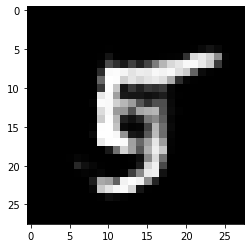

In [21]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [22]:
# deney
# ilk deney koşula uygun n adet yani birden fazla sentetik veri üretebilir miyiz?
# ikinci deney farklı koşullar için tekrar ve tekrar model eğitmek ile tek bir model eğitmek arasında ne gibi maliyet farkı var?

In [23]:
# deney 1:

In [24]:
latent_dim = 100
num_images = 49
random_latent_vectors = tf.random.normal(shape=(num_images, latent_dim))
generated_images = generator(random_latent_vectors)

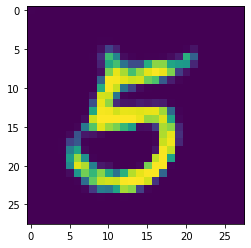

In [26]:
plt.imshow(generated_images[10])

In [ ]:
# deney 2:

In [28]:
%%time
# vanilla gan tüm veriler ile eğitiliyor.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
discriminator = Discriminator()
generator = Generator()
gan = GAN(discriminator, generator, latent_dim)
gan.compile(discriminator_optimizer, generator_optimizer, loss_fn)
gan.fit(train_dataset, epochs=50)

Epoch 1/50
1875/1875 [==============================] - 40s 21ms/step - d_loss: 0.6393 - g_loss: 0.8706
Epoch 2/50
1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6439 - g_loss: 0.8254
Epoch 3/50
1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6390 - g_loss: 0.8355
Epoch 4/50
1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6446 - g_loss: 0.8191
Epoch 5/50
1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6448 - g_loss: 0.80461s - d_loss: 0.6448 - g_lo - ETA: 0s - d
Epoch 6/50
1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6474 - g_loss: 0.8003
Epoch 7/50
1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6455 - g_loss: 0.7929
Epoch 8/50
1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6436 - g_loss: 0.78590s - d_l
Epoch 9/50
1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6439 - g_loss: 0.7780
Epoch 10/50
1875

32 dk 46 saniye - 60000x28x28

In [30]:
%%time
for spec in range(10):
    indices = np.where(train_labels == spec)[0]
    train_images_spec = []
    for i in range(len(train_labels)):
        if i in indices:
            train_images_spec.append(train_images[i])

    train_images_spec = np.array(train_images_spec)
    train_dataset = tf.data.Dataset.from_tensor_slices(train_images_spec).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    print("for spec:", spec)
    print("len train_images_spec:", len(train_images_spec))
    
    discriminator = Discriminator()
    generator = Generator()
    gan = GAN(discriminator, generator, latent_dim)
    gan.compile(discriminator_optimizer, generator_optimizer, loss_fn)
    gan.fit(train_dataset, epochs=50)

for spec: 0
len train_images_spec: 5923
Epoch 1/50
186/186 [==============================] - 5s 22ms/step - d_loss: 0.5998 - g_loss: 1.2833
Epoch 2/50
186/186 [==============================] - 4s 21ms/step - d_loss: 0.6663 - g_loss: 0.8058
Epoch 3/50
186/186 [==============================] - 4s 21ms/step - d_loss: 0.6844 - g_loss: 0.7590
Epoch 4/50
186/186 [==============================] - 4s 21ms/step - d_loss: 0.6867 - g_loss: 0.7429
Epoch 5/50
186/186 [==============================] - 4s 21ms/step - d_loss: 0.6890 - g_loss: 0.7365
Epoch 6/50
186/186 [==============================] - 4s 21ms/step - d_loss: 0.6902 - g_loss: 0.7330
Epoch 7/50
186/186 [==============================] - 4s 21ms/step - d_loss: 0.6882 - g_loss: 0.7382
Epoch 8/50
186/186 [==============================] - 4s 21ms/step - d_loss: 0.6879 - g_loss: 0.7421
Epoch 9/50
186/186 [==============================] - 4s 21ms/step - d_loss: 0.6878 - g_loss: 0.7434
Epoch 10/50
186/186 [==============================

192/192 [==============================] - 4s 21ms/step - d_loss: 0.6817 - g_loss: 0.7379 0s - d_loss: 0.6815 - g_loss: 
Epoch 7/50
192/192 [==============================] - 4s 21ms/step - d_loss: 0.6807 - g_loss: 0.7383
Epoch 8/50
192/192 [==============================] - 4s 21ms/step - d_loss: 0.6810 - g_loss: 0.7341 0s - d_loss: 0.6811 - g_lo
Epoch 9/50
192/192 [==============================] - 4s 21ms/step - d_loss: 0.6837 - g_loss: 0.7384
Epoch 10/50
192/192 [==============================] - 4s 21ms/step - d_loss: 0.6818 - g_loss: 0.7350
Epoch 11/50
192/192 [==============================] - 4s 21ms/step - d_loss: 0.6823 - g_loss: 0.7352
Epoch 12/50
192/192 [==============================] - 4s 21ms/step - d_loss: 0.6823 - g_loss: 0.7356
Epoch 13/50
192/192 [==============================] - 4s 21ms/step - d_loss: 0.6814 - g_loss: 0.7318
Epoch 14/50
192/192 [==============================] - 4s 21ms/step - d_loss: 0.6808 - g_loss: 0.7368
Epoch 15/50
192/192 [==================

183/183 [==============================] - 4s 21ms/step - d_loss: 0.6808 - g_loss: 0.7624
Epoch 36/50
183/183 [==============================] - 4s 21ms/step - d_loss: 0.6824 - g_loss: 0.7593
Epoch 37/50
183/183 [==============================] - 4s 21ms/step - d_loss: 0.6814 - g_loss: 0.7618
Epoch 38/50
183/183 [==============================] - 4s 21ms/step - d_loss: 0.6839 - g_loss: 0.7602
Epoch 39/50
183/183 [==============================] - 4s 21ms/step - d_loss: 0.6807 - g_loss: 0.7620
Epoch 40/50
183/183 [==============================] - 4s 21ms/step - d_loss: 0.6808 - g_loss: 0.7631
Epoch 41/50
183/183 [==============================] - 4s 21ms/step - d_loss: 0.6809 - g_loss: 0.7626
Epoch 42/50
183/183 [==============================] - 4s 21ms/step - d_loss: 0.6812 - g_loss: 0.7597 0s - d
Epoch 43/50
183/183 [==============================] - 4s 21ms/step - d_loss: 0.6799 - g_loss: 0.7636
Epoch 44/50
183/183 [==============================] - 4s 21ms/step - d_loss: 0.6796 - 

196/196 [==============================] - 4s 21ms/step - d_loss: 0.6854 - g_loss: 0.7536
Epoch 41/50
196/196 [==============================] - 4s 21ms/step - d_loss: 0.6857 - g_loss: 0.7551
Epoch 42/50
196/196 [==============================] - 4s 21ms/step - d_loss: 0.6850 - g_loss: 0.7545
Epoch 43/50
196/196 [==============================] - 4s 21ms/step - d_loss: 0.6843 - g_loss: 0.7538
Epoch 44/50
196/196 [==============================] - 4s 21ms/step - d_loss: 0.6836 - g_loss: 0.7540
Epoch 45/50
196/196 [==============================] - 4s 21ms/step - d_loss: 0.6843 - g_loss: 0.7518
Epoch 46/50
196/196 [==============================] - 4s 21ms/step - d_loss: 0.6846 - g_loss: 0.7537
Epoch 47/50
196/196 [==============================] - 4s 21ms/step - d_loss: 0.6828 - g_loss: 0.7526
Epoch 48/50
196/196 [==============================] - 4s 21ms/step - d_loss: 0.6839 - g_loss: 0.7535
Epoch 49/50
196/196 [==============================] - 4s 21ms/step - d_loss: 0.6835 - g_loss:

33 dk - her veri ayrı ayrı

In [ ]:
# Aşarısı sadece modellerin çıktısını test etmek için

In [33]:
%%time
list_img = []
for spec in range(10):
    indices = np.where(train_labels == spec)[0]
    train_images_spec = []
    for i in range(len(train_labels)):
        if i in indices:
            train_images_spec.append(train_images[i])

    train_images_spec = np.array(train_images_spec)
    train_dataset = tf.data.Dataset.from_tensor_slices(train_images_spec).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    print("spec:", spec)
    print("len train_images_spec:", len(train_images_spec))
    print("ilk on:", indices[:10])
    
    discriminator = Discriminator()
    generator = Generator()
    gan = GAN(discriminator, generator, latent_dim)
    gan.compile(discriminator_optimizer, generator_optimizer, loss_fn)
    gan.fit(train_dataset, epochs=20)
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise)
    list_img.append(generated_image[0, :, :, 0])
    #plt.imshow(generated_image[0, :, :, 0], cmap='gray')

spec: 0
len train_images_spec: 5923
ilk on: [ 1 21 34 37 51 56 63 68 69 75]
Epoch 1/20
186/186 [==============================] - 5s 22ms/step - d_loss: 0.6150 - g_loss: 1.1365
Epoch 2/20
186/186 [==============================] - 4s 21ms/step - d_loss: 0.6674 - g_loss: 0.7952
Epoch 3/20
186/186 [==============================] - 4s 21ms/step - d_loss: 0.6772 - g_loss: 0.7596
Epoch 4/20
186/186 [==============================] - 4s 21ms/step - d_loss: 0.6827 - g_loss: 0.7464
Epoch 5/20
186/186 [==============================] - 4s 21ms/step - d_loss: 0.6873 - g_loss: 0.7397
Epoch 6/20
186/186 [==============================] - 4s 21ms/step - d_loss: 0.6890 - g_loss: 0.7395
Epoch 7/20
186/186 [==============================] - 4s 21ms/step - d_loss: 0.6878 - g_loss: 0.7382
Epoch 8/20
186/186 [==============================] - 4s 21ms/step - d_loss: 0.6874 - g_loss: 0.7387
Epoch 9/20
186/186 [==============================] - 4s 21ms/step - d_loss: 0.6879 - g_loss: 0.7382
Epoch 10/20
186

196/196 [==============================] - 4s 21ms/step - d_loss: 0.6853 - g_loss: 0.7574 0s - d_loss: 0.6851 - 
Epoch 11/20
196/196 [==============================] - 4s 21ms/step - d_loss: 0.6845 - g_loss: 0.7602
Epoch 12/20
196/196 [==============================] - 4s 21ms/step - d_loss: 0.6866 - g_loss: 0.7587
Epoch 13/20
196/196 [==============================] - 4s 21ms/step - d_loss: 0.6850 - g_loss: 0.7580
Epoch 14/20
196/196 [==============================] - 4s 21ms/step - d_loss: 0.6859 - g_loss: 0.7568
Epoch 15/20
196/196 [==============================] - 4s 21ms/step - d_loss: 0.6863 - g_loss: 0.7560
Epoch 16/20
196/196 [==============================] - 4s 21ms/step - d_loss: 0.6872 - g_loss: 0.7545
Epoch 17/20
196/196 [==============================] - 4s 21ms/step - d_loss: 0.6866 - g_loss: 0.7556
Epoch 18/20
196/196 [==============================] - 4s 21ms/step - d_loss: 0.6866 - g_loss: 0.7561
Epoch 19/20
196/196 [==============================] - 4s 21ms/step - d

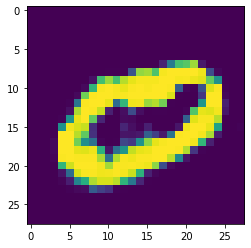

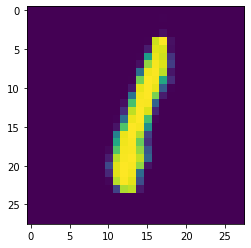

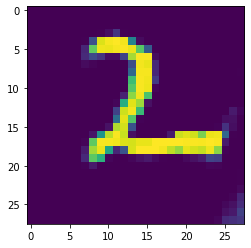

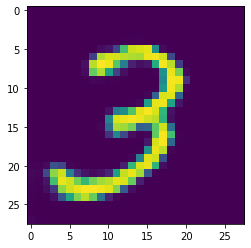

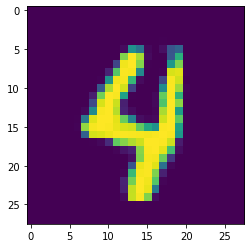

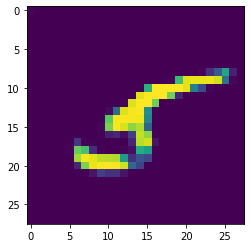

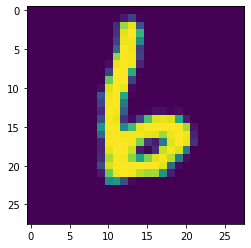

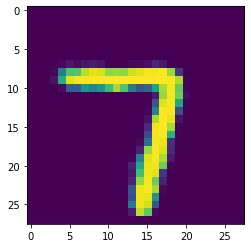

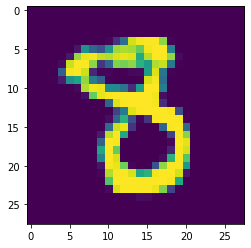

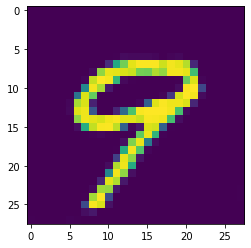

In [48]:
for i in range(10):
    plt.imshow(list_img[i])
    plt.show()

Not: Şu anda ilk aşama tamamlandı. Yani görsel veriler için belirli bir koşula uygun veri üretimi vanilla gan kullanılarak gerçekleştirildi.

Birden fazla örnek oluşturma veya oluşturulan örneklerin gösterilmesi ile ilgili bir problem gözlemlenmedi.

Ayrıca modellerin tek tek eğitilmesi veya tüm verilerin aynı anda koşuldan bağımsız eğitilmesi konusunda bir zaman farkı bulunmamaktadır.

Bizim verilerimizin çok fazla boyuta sahip olduğu için bu kadar uzun sürdü eğitimler örneğin, adult veri seti 32.500x15 boyutundadır, bizim görsel veri setimiz 60.000x48x48 yani yaklaşık 96 katı boyutunda.

Burada bir sonraki aşama tabular data için eğitim gerçekleştirebilmektir.
Daha sonrasında işlemlerin fonksiyonlaştırılması ve nesneye yönelimli programlama yapısında py dosyası formatına getirilmesidir.

En sonunda da bu modelin eğitimi hızlandırılmaya çalışılabilir. Veriyi temsil eden en iyi bir örneklem seçilebilir vs. veya paralelleştirme denenebilir. Modelin içine koşul verilmeye çalışılabilir. Early stopping eklenebilir. Veri boyutuna bağlı epoch sayısı belirlenebilir. Fakat version 1 için elde çalışan bir yapının bulunması iyi olacaktır. 